#Import Required Libraries and Modules

Load all necessary Python libraries and project-specific modules.



In [ ]:
%%capture
!pip install pykeen==1.10.1 class-resolver==0.3.10

In [ ]:
from model import TransEModel #model.py
from data import KGDataHandler #data.py
import matplotlib.pyplot as plt


In [ ]:
%%capture
!pip install opacus

In [ ]:
from trainer import TransETrainer #trainer.py

#Load and Prepare Dataset

Download and initialize the dataset for training and evaluation.

In [ ]:
# Download dataset
fb_path = kagglehub.dataset_download("latebloomer/fb15k-237")
print("Path to dataset files:", fb_path)


100%|██████████| 3.63M/3.63M [00:00<00:00, 5.34MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/latebloomer/fb15k-237/versions/1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#Define Configuration Parameters

Set all hyperparameters and training options in a centralized config dictionary.

In [ ]:
# Configuration parameters
config = {
    'embedding_dim': 100,          # Size of the embedding vectors
    'learning_rate': 0.005,        # Step size for optimizer updates
    'noise_multiplier': 0.7,       # Amount of noise added for differential privacy
    'batch_size': 256,             # Number of samples per training batch
    'norm_clipping': 1.0,          # Maximum L2 norm of per-sample gradients
    'margin': 0.5,                 # Margin for ranking loss
    'epochs': 300,                 # Total number of training iterations
    'confidential_ratio': 0.3,     # Fraction of training data needing privacy
    'device': device
}

#Initialise Data Handler and Model

Set up the knowledge graph data processor and instantiate the TransE model.

In [ ]:
# Initialize data handler
data_handler = KGDataHandler(fb_path, confidential_ratio=config['confidential_ratio'])
data_handler.print_data_stats()

# Initialize model
model = TransEModel(
    entity_count=data_handler.entity_count,
    relation_count=data_handler.relation_count,
    embedding_dim=config['embedding_dim'],
    device=config['device']
)

--------------------------------------------------------------------------------
Total entities: 14505
--------------------------------------------------------------------------------
Total relations: 237
--------------------------------------------------------------------------------
Confidential triples: 81634
--------------------------------------------------------------------------------
Unrestricted triples: 190481
--------------------------------------------------------------------------------
Testing triples: 20438


#Train the Model with Early Stopping


Begin model training, monitoring loss and privacy metrics with early stopping.

In [ ]:
# Initialize trainer
trainer = TransETrainer(
    model=model,
    data_handler=data_handler,
    learning_rate=config['learning_rate'],
    noise_multiplier=config['noise_multiplier'],
    batch_size=config['batch_size'],
    norm_clipping=config['norm_clipping'],
    margin=config['margin'],
    epochs=config['epochs'],
    device=config['device']
)



In [ ]:
# Start training with early stopping
print("Starting training with early stopping...")
best_model, training_losses, epsilon_values,all_metrics = trainer.train_with_early_stopping(patience=5)

Starting training with early stopping...
Epoch 1/300
  Epoch 1: mU=743, mC=319, avg_loss=0.4613
  Validation: MR=6020.39, MRR=0.0219, Hits@10=0.0410
  Current privacy guarantee: (ε = 2.19, δ = 1e-5)
Epoch 2/300
  Epoch 2: mU=1487, mC=637, avg_loss=0.4807
Epoch 3/300
  Epoch 3: mU=2230, mC=956, avg_loss=0.4825
Epoch 4/300
  Epoch 4: mU=2973, mC=1275, avg_loss=0.4827
Epoch 5/300
  Epoch 5: mU=3717, mC=1593, avg_loss=0.4823
Epoch 6/300
  Epoch 6: mU=4460, mC=1912, avg_loss=0.4791
  Current privacy guarantee: (ε = 2.78, δ = 1e-5)
Epoch 7/300
  Epoch 7: mU=5204, mC=2230, avg_loss=0.4763
Epoch 8/300
  Epoch 8: mU=5947, mC=2549, avg_loss=0.4742
Epoch 9/300
  Epoch 9: mU=6690, mC=2868, avg_loss=0.4738
Epoch 10/300
  Epoch 10: mU=7434, mC=3186, avg_loss=0.4717
Epoch 11/300
  Epoch 11: mU=8177, mC=3505, avg_loss=0.4681
  Validation: MR=6004.38, MRR=0.0271, Hits@10=0.0540
  Current privacy guarantee: (ε = 3.20, δ = 1e-5)
Epoch 12/300
  Epoch 12: mU=8921, mC=3823, avg_loss=0.4664
Epoch 13/300
  Ep

In [ ]:
best_model["metrics"]

{'MR': np.float64(4714.325),
 'MRR': np.float64(0.07739189103577493),
 'Hits@1': 0.01,
 'Hits@3': 0.134,
 'Hits@10': 0.179,
 'epoch': 150}

In [ ]:
all_metrics

[{'MR': np.float64(6020.39),
  'MRR': np.float64(0.021940937038725253),
  'Hits@1': 0.008,
  'Hits@3': 0.031,
  'Hits@10': 0.041,
  'epoch': 0},
 {'MR': np.float64(6004.383),
  'MRR': np.float64(0.02705171430513257),
  'Hits@1': 0.002,
  'Hits@3': 0.048,
  'Hits@10': 0.054,
  'epoch': 10},
 {'MR': np.float64(5783.059),
  'MRR': np.float64(0.03083065756904648),
  'Hits@1': 0.002,
  'Hits@3': 0.054,
  'Hits@10': 0.066,
  'epoch': 20},
 {'MR': np.float64(5322.891),
  'MRR': np.float64(0.0498476038639802),
  'Hits@1': 0.004,
  'Hits@3': 0.088,
  'Hits@10': 0.109,
  'epoch': 30},
 {'MR': np.float64(5508.187),
  'MRR': np.float64(0.045401339550636514),
  'Hits@1': 0.002,
  'Hits@3': 0.082,
  'Hits@10': 0.104,
  'epoch': 40},
 {'MR': np.float64(5471.701),
  'MRR': np.float64(0.0634816517527356),
  'Hits@1': 0.006,
  'Hits@3': 0.116,
  'Hits@10': 0.137,
  'epoch': 50},
 {'MR': np.float64(5605.1),
  'MRR': np.float64(0.044985511763809716),
  'Hits@1': 0.004,
  'Hits@3': 0.079,
  'Hits@10': 0.10

#Plot Training Loss Curve

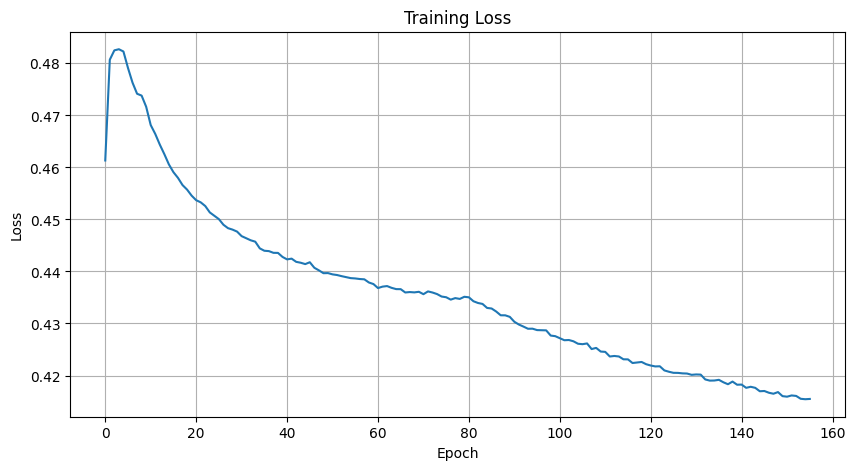

In [ ]:
# Visualize how the training loss evolves over epochs to assess convergence.
plt.figure(figsize=(10, 5))
plt.plot(training_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()






#Plot Evaluation Metrics

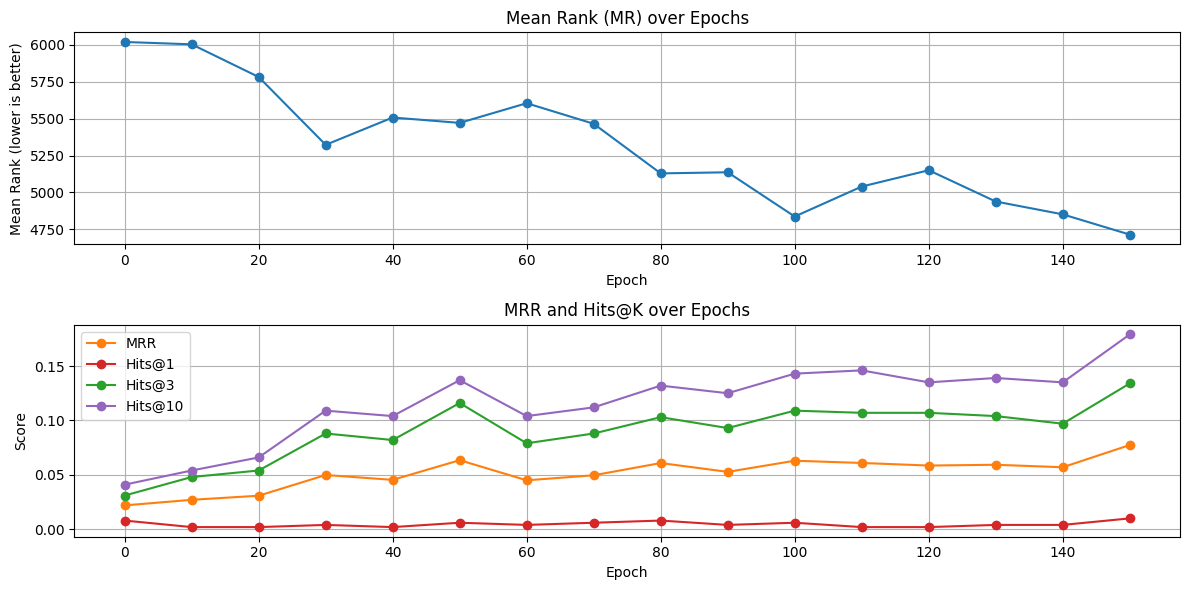

In [ ]:
#Display performance metrics (e.g., MRR, Hits@K) and epsilon values over time.

# Extract values
epochs = [m['epoch'] for m in all_metrics]
mr = [m['MR'] for m in all_metrics]
mrr = [m['MRR'] for m in all_metrics]
hits1 = [m['Hits@1'] for m in all_metrics]
hits3 = [m['Hits@3'] for m in all_metrics]
hits10 = [m['Hits@10'] for m in all_metrics]

# Plot
plt.figure(figsize=(12, 6))

# Plot MR
plt.subplot(2, 1, 1)
plt.plot(epochs, mr, marker='o', color='tab:blue')
plt.title("Mean Rank (MR) over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Rank (lower is better)")
plt.grid(True)

# Plot MRR and Hits@
plt.subplot(2, 1, 2)
plt.plot(epochs, mrr, marker='o', label="MRR", color='tab:orange')
plt.plot(epochs, hits1, marker='o', label="Hits@1", color='tab:red')
plt.plot(epochs, hits3, marker='o', label="Hits@3", color='tab:green')
plt.plot(epochs, hits10, marker='o', label="Hits@10", color='tab:purple')
plt.title("MRR and Hits@K over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.savefig('MR, MRR, Hits@R.png')
plt.tight_layout()
plt.show()
